In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from wordcloud import WordCloud
from collections import Counter


In [2]:
# Downloadin required NLTK data
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

### Loading the dataset

In [3]:
# loading the dataset
df = pd.read_csv('./dataset.csv', encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'query', 'user', 'text']
df.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Text Processing

In [4]:
# Initializing the stopwords and lemmatizer/stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [7]:
df = df[["text", "target"]]

In [8]:
# Text preprocessing
def text_processing(text):
    # Step 1 : Convert to lowercase
    text = str(text).lower()
    # Step 2: Remove URLs
    text = re.sub(r"http\S+", "", text)    
    # Step 3: Remove Mentions and  hashtags
    text = re.sub(r"@\w+", "", text)     
    # Step 4: Remove punctuations and special characters
    text = re.sub(r"[^a-zA-Z0-9\s!?']", "", text)   
    text = re.sub(r"\s+", " ", text).strip()        
    return text


In [9]:
df['text'] = df['text'].apply(text_processing)

In [11]:
# Initial Sampling
sample_result = train_test_split(
    df, 
    stratify=df["target"], 
    train_size=1000000, 
    random_state=42
)
df_sampled = sample_result[0]
X, y = df_sampled["text"], df_sampled["target"]



In [12]:
# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Second split: train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

### Logistic Regression Model

In [13]:
# Transform data
tfidf_vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2))
# Train Model
logistic_classifier = LogisticRegression(C=0.7, penalty="l2", max_iter=1000)


In [14]:
# Pipeline
pipeline = Pipeline([
    ("tfidf", tfidf_vectorizer),
    ("lr", logistic_classifier)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=7000, ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=0.7, max_iter=1000))])

In [15]:
# Model Evaluation
y_train_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)
y_test_pred = pipeline.predict(X_test)

# Compute Accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
validation_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy :",train_accuracy )
print("Validation Accuracy :",validation_accuracy )
print("Testing Accuracy :",test_accuracy )

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))

Training Accuracy : 0.8025529483195828
Validation Accuracy : 0.7981203132811198
Testing Accuracy : 0.7991933333333333

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     75000
           4       0.79      0.81      0.80     75000

    accuracy                           0.80    150000
   macro avg       0.80      0.80      0.80    150000
weighted avg       0.80      0.80      0.80    150000



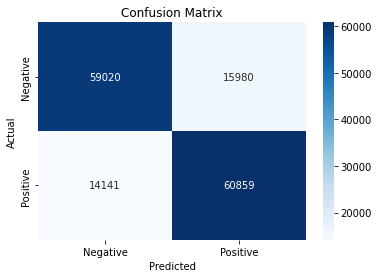

In [16]:
# Confusion Matrix
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### SVM Model

In [17]:
# SVM model
svm_linear_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=7000, ngram_range=(1, 2))),
    ("svc", LinearSVC(C=0.5, max_iter=1000, random_state=42))
])
svm_linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=7000, ngram_range=(1, 2))),
                ('svc', LinearSVC(C=0.5, random_state=42))])

In [18]:
# Model Evaluation
svm_y_train_pred = svm_linear_pipeline.predict(X_train)
svm_y_val_pred = svm_linear_pipeline.predict(X_val)
svm_y_test_pred = svm_linear_pipeline.predict(X_test)

# Compute Accuracies
svm_train_accuracy = accuracy_score(y_train, svm_y_train_pred)
svm_validation_accuracy = accuracy_score(y_val, svm_y_val_pred)
svm_test_accuracy = accuracy_score(y_test, svm_y_test_pred)

print("Training Accuracy :",svm_train_accuracy )
print("Validation Accuracy :",svm_validation_accuracy )
print("Testing Accuracy :",svm_test_accuracy )

print("\nClassification Report:\n")
print(classification_report(y_test, svm_y_test_pred))

Training Accuracy : 0.8023415121968642
Validation Accuracy : 0.796460589901683
Testing Accuracy : 0.79864

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.78      0.80     75000
           4       0.79      0.81      0.80     75000

    accuracy                           0.80    150000
   macro avg       0.80      0.80      0.80    150000
weighted avg       0.80      0.80      0.80    150000



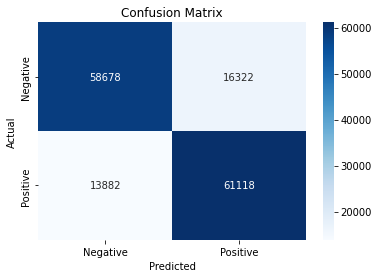

In [19]:
# Confusion Matrix
y_pred = svm_linear_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Naive Bayes Model

In [20]:
# Multinomial Naive Bayes model
nb_multinomial_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=7000, ngram_range=(1, 2))),
    ("nb", MultinomialNB(alpha=1.0))
])
nb_multinomial_pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=7000, ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

In [21]:
# Model Evaluation
nb_y_train_pred = nb_multinomial_pipeline.predict(X_train)
nb_y_val_pred = nb_multinomial_pipeline.predict(X_val)
nb_y_test_pred = nb_multinomial_pipeline.predict(X_test)

# Compute Accuracies
nb_train_accuracy = accuracy_score(y_train, nb_y_train_pred)
nb_validation_accuracy = accuracy_score(y_val, nb_y_val_pred)
nb_test_accuracy = accuracy_score(y_test, nb_y_test_pred)

print("Training Accuracy :",nb_train_accuracy )
print("Validation Accuracy :",nb_validation_accuracy )
print("Testing Accuracy :",nb_test_accuracy )

print("\nClassification Report:\n")
print(classification_report(y_test, nb_y_test_pred))

Training Accuracy : 0.7795592699739277
Validation Accuracy : 0.7764772537910348
Testing Accuracy : 0.7783933333333334

Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     75000
           4       0.78      0.77      0.78     75000

    accuracy                           0.78    150000
   macro avg       0.78      0.78      0.78    150000
weighted avg       0.78      0.78      0.78    150000



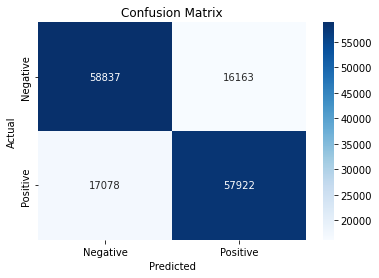

In [22]:
# Confusion Matrix
y_pred = nb_multinomial_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()